In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("/Users/iavompe/Downloads/Tables/dim_transactions.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391425 entries, 0 to 391424
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   account_id          391425 non-null  int64  
 1   transaction_amount  391425 non-null  int64  
 2   transaction_date    391425 non-null  object 
 3   total_usd           388855 non-null  float64
 4   total_coins         391425 non-null  int64  
 5   payment_method      391425 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 17.9+ MB


In [ ]:
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

In [4]:
df = df.fillna(0)
df


,account_id,transaction_amount,transaction_date,total_usd,total_coins,payment_method
0,2727244212,2,2021-10-17,0.00,0,Other
1,2645120520,12,2021-10-18,0.00,0,Other
2,2728137002,2,2021-10-20,0.00,0,Other
3,2645120520,2,2021-10-19,0.00,0,Other
4,2555209854,56,2021-10-21,0.00,0,Other
...,...,...,...,...,...,...
391420,2728701450,5,2021-12-07,79.43,10750,Other
391421,2761665631,7,2021-12-12,114.93,17150,Credit Card
391422,597472908,2,2021-12-08,249.98,42750,Credit Card
391423,2623311958,8,2021-12-11,13.92,1535,Other


In [5]:
# review the numerical values
pd.options.display.float_format = '{:,.2f}'.format
df[["total_usd", "total_coins"]].describe()

,total_usd,total_coins
count,"391,425.00","391,425.00"
mean,25.79,"3,455.98"
std,116.81,"18,019.75"
min,-0.53,0.00
25%,1.92,200.00
50%,4.99,500.00
75%,18.94,"2,100.00"
max,"13,797.57","2,335,000.00"


In [6]:
# RFM Analysis
# Recency: days since last transaction
# Frequency: number of transactions
# Monetary: total amount spent

In [7]:
# Max observation date + 1
today_date = dt.datetime(2022, 1, 1)

# RFM Calculation
rfm = df.groupby('account_id').agg({
    'transaction_date': lambda x: (today_date - x.max()).days,
    'account_id': 'count',
    'total_usd': 'sum'
})

rfm.rename(columns={
    'transaction_date': 'Recency',
    'account_id': 'Frequency',
    'total_usd': 'Monetary'
}, inplace=True)

print(rfm)

            Recency  Frequency  Monetary
account_id                              
9524              5          3     50.96
9692              1         53    761.74
14322            11          1      9.32
22152            72          1      3.74
27926            18          2      5.98
...             ...        ...       ...
2777933479        1          1      2.29
2777934763        1          1      1.94
2777947147        1          1      2.12
2777958913        1          1      1.14
2777962087        1          1     19.99

[52829 rows x 3 columns]


In [8]:
def create_ranks(column, num_bins=4):
    bin_count = len(pd.qcut(column, q=num_bins, duplicates='drop').cat.categories)
    labels = list(range(bin_count, 0, -1))
    return pd.qcut(column, q=bin_count, labels=labels, duplicates='drop')

rfm['R_rank'] = create_ranks(rfm['Recency'])
rfm['F_rank'] = create_ranks(rfm['Frequency'])
rfm['M_rank'] = create_ranks(rfm['Monetary'])

rfm['RFM_Score'] = rfm['R_rank'].astype(str) + rfm['F_rank'].astype(str) + rfm['M_rank'].astype(str)

print(rfm[['Recency', 'Frequency', 'Monetary', 'RFM_Score']])

            Recency  Frequency  Monetary RFM_Score
account_id                                        
9524              5          3     50.96       422
9692              1         53    761.74       411
14322            11          1      9.32       333
22152            72          1      3.74       134
27926            18          2      5.98       333
...             ...        ...       ...       ...
2777933479        1          1      2.29       434
2777934763        1          1      1.94       434
2777947147        1          1      2.12       434
2777958913        1          1      1.14       434
2777962087        1          1     19.99       432

[52829 rows x 4 columns]


In [23]:
# Here we can play with rank step(use more than 4 groups), try other conditions and group boundaries, etc...
def segment_customer(row):
    if row['R_rank'] == 4 and row['F_rank'] >= 3 and row['M_rank'] <= 2:
        return 'Champions'
    elif row['R_rank'] == 3 and row['F_rank'] == 3 and row['M_rank'] == 1:
        return 'Loyal Big Spenders'
    elif row['R_rank'] >= 3 and row['F_rank'] >= 3 and row['M_rank'] >= 3:
        return 'Loyal Low Spenders'
    elif row['R_rank'] == 4 and row['F_rank'] < 3:
        return 'Potential Loyalists'
    elif row['R_rank'] <= 2 and row['F_rank'] >= 3 and row['M_rank'] <= 2:
        return 'At Risk'
    elif row['R_rank'] == 1 and row['F_rank'] <= 2:
        return 'Lost Customers'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)

print(rfm[['Recency', 'Frequency', 'Monetary', 'RFM_Score', 'Segment']])

            Recency  Frequency  Monetary RFM_Score              Segment
account_id                                                             
9524              5          3     50.96       422  Potential Loyalists
9692              1         53    761.74       411  Potential Loyalists
14322            11          1      9.32       333   Loyal Low Spenders
22152            72          1      3.74       134               Others
27926            18          2      5.98       333   Loyal Low Spenders
...             ...        ...       ...       ...                  ...
2777933479        1          1      2.29       434   Loyal Low Spenders
2777934763        1          1      1.94       434   Loyal Low Spenders
2777947147        1          1      2.12       434   Loyal Low Spenders
2777958913        1          1      1.14       434   Loyal Low Spenders
2777962087        1          1     19.99       432            Champions

[52829 rows x 5 columns]


In [25]:
segment_counts = rfm['Segment'].value_counts()
print(segment_counts)

segment_analysis = rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

print(segment_analysis)

Segment
Others                 30401
Potential Loyalists    11405
Loyal Low Spenders      4803
Lost Customers          3263
At Risk                 2471
Champions                359
Loyal Big Spenders       127
Name: count, dtype: int64
               Segment  Recency  Frequency  Monetary
0              At Risk    54.79       1.50     67.86
1            Champions     2.65       1.67     64.70
2       Lost Customers    62.95       5.29    101.69
3   Loyal Big Spenders    12.17       1.65    300.76
4   Loyal Low Spenders     8.60       1.37      4.26
5               Others    35.30       5.34    102.71
6  Potential Loyalists     2.49      17.59    560.30


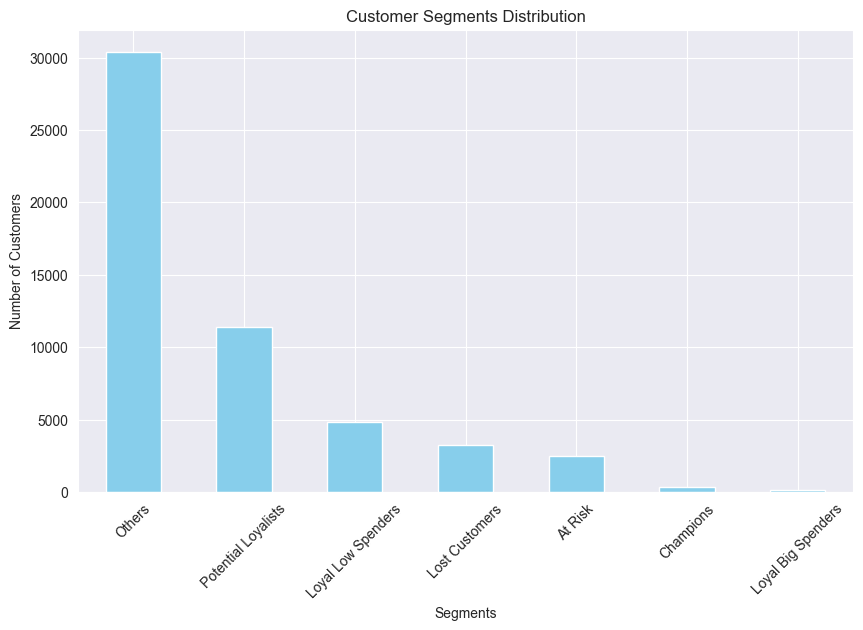

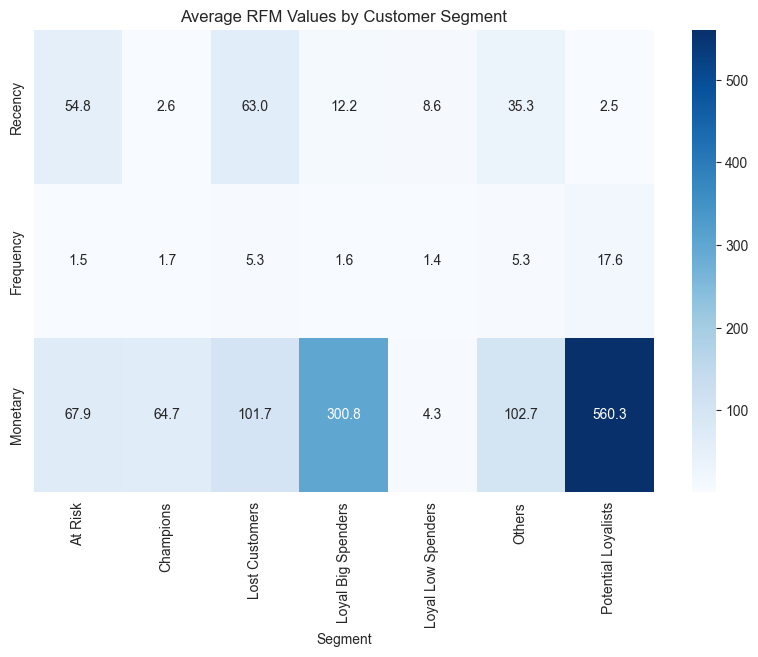

In [26]:
# Plots
plt.figure(figsize=(10, 6))
segment_counts.plot(kind='bar', color='skyblue')
plt.title('Customer Segments Distribution')
plt.ylabel('Number of Customers')
plt.xlabel('Segments')
plt.xticks(rotation=45)
plt.show()

# Heatmap of average RFM values per segment
plt.figure(figsize=(10, 6))
sns.heatmap(segment_analysis.set_index('Segment').T, annot=True, cmap='Blues', fmt=".1f")
plt.title('Average RFM Values by Customer Segment')
plt.show()

In [12]:
# Champions: segment consist of users, who represent your most valuable customers. We should prioritize retention efforts here.

# Loyal Big Spenders: These are also important for driving recurring revenue, like Champions, so focus on keeping them engaged with relevant offers.

# Loyal Low Spenders: Focus on engaging this group with targeted offers and personalized marketing efforts to increase their average spend.

# At Risk: These customers show a decline in engagement but were valuable in the past, so personalized win-back campaigns could help re-activate them.

# Lost Customers: Customers who have disengaged may require more aggressive campaigns or could be removed from high-cost marketing efforts if they’re not likely to return.

# Potential Loyalists: We can make deeper analysis, maybe split this segment to more groups.

# Others: Dive deep into analysis of this group, like for Potential Loyalists